# Building a model to classify an image of Cat and Dog.

## 1.Importing the libraries

In [133]:
import os
import numpy as np
import random
import itertools
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import shutil
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

## 2.Creating directories for appropriate labels. 

In [2]:
#Specifying the labels
labels = ['daisy','dandelion','rose','sunflower','tulip']
labels.sort()#sorting the label for uniformity

#Defining source data
data = 'flowers/'

#defining split size
split_size = 0.9 #90% Train, 5% Validation, 5% Test

In [3]:
try:
    for label in labels:
        os.makedirs('labels/train/{}'.format(label))
        os.makedirs('labels/val/{}'.format(label))
        os.makedirs('labels/test/{}'.format(label))
except OSError :
    pass

In [25]:
for label in labels:
    img_lis = os.listdir(data+label)
    for i in range(len(img_lis)):
        if i < len(img_lis)*split_size:
            shutil.copyfile('{}{}/{}'.format(data,label,img_lis[i]), 'labels/train/{}/{}'.format(label,img_lis[i]))
        elif i < len(img_lis)*(split_size + 0.05):
            shutil.copyfile('{}{}/{}'.format(data,label,img_lis[i]), 'labels/val/{}/{}'.format(label,img_lis[i]))
        else :
            shutil.copyfile('{}{}/{}'.format(data,label,img_lis[i]), 'labels/test/{}/{}'.format(label,img_lis[i]))

## 3.Using ImageGenerator for Image Augmentation and to load the data with appropriate labels.  

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range =40,
                                  width_shift_range =0.2,
                                  height_shift_range = 0.2,
                                  shear_range =0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip =True,
                                  fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    'labels/train',
    target_size=(299,299)
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    'labels/val',
    target_size=(299,299)
)
    
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    'labels/test',
    target_size=(299,299),
    shuffle=False
)

Found 3896 images belonging to 5 classes.
Found 216 images belonging to 5 classes.
Found 211 images belonging to 5 classes.


## 4.Building a model to train the data on. 

In [5]:
red_lr = ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.1,verbose=1)

In [10]:
#Getting object of the InceptionResNet pre-trained model

IRN = InceptionResNetV2(include_top=False, input_shape=(299,299,3))
for layers in IRN.layers:
    layers.trainable = False

x = IRN.output
x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = Dense(5,activation='sigmoid')(x)

model = Model(inputs = IRN.input, outputs = x)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 149, 149, 32) 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 149, 149, 32) 0           batch_normalization_406[0][0]    
______________________________________________________________________________________________

## 5.Training the model. 

In [22]:
model.compile(optimizer=Adam(0.001),loss=categorical_crossentropy,metrics=['accuracy'])
history = model.fit(train_generator, validation_data=val_generator,callbacks=red_lr, epochs=25,verbose=1)

Epoch 1/25
122/122 [==============================] - 131s 993ms/step - loss: 14.6493 - accuracy: 0.5535 - val_loss: 0.8906 - val_accuracy: 0.7870
Epoch 2/25
122/122 [==============================] - 97s 792ms/step - loss: 0.8848 - accuracy: 0.7711 - val_loss: 0.4036 - val_accuracy: 0.8426
Epoch 3/25
122/122 [==============================] - 97s 791ms/step - loss: 0.5710 - accuracy: 0.8213 - val_loss: 0.4730 - val_accuracy: 0.8611
Epoch 4/25
122/122 [==============================] - 97s 794ms/step - loss: 0.5054 - accuracy: 0.8329 - val_loss: 0.2831 - val_accuracy: 0.8843
Epoch 5/25
122/122 [==============================] - 97s 794ms/step - loss: 0.4663 - accuracy: 0.8424 - val_loss: 0.3282 - val_accuracy: 0.8843
Epoch 6/25
122/122 [==============================] - 99s 811ms/step - loss: 0.3961 - accuracy: 0.8611 - val_loss: 0.4354 - val_accuracy: 0.8796
Epoch 7/25
122/122 [==============================] - 97s 790ms/step - loss: 0.4873 - accuracy: 0.8460 - val_loss: 0.2897 - val_

Text(0.5, 1.0, 'Training and validation loss')

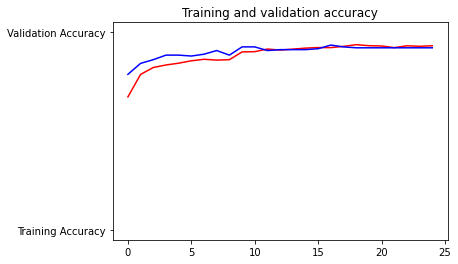

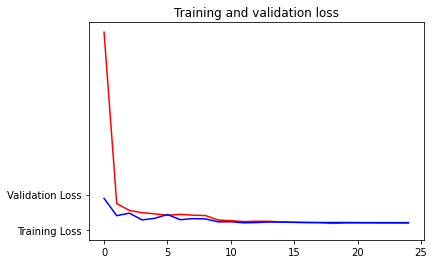

In [23]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [ ]:
#model.save('model_95')
model = load_model('model_95')

## 6.Making predictions on unseen data(test_dataset) 

In [118]:
#Making a list to get test labels and image names.
x_test = []
y_test = []

for label in labels:
    img_lis = os.listdir('labels/test/{}'.format(label))
    for i in range(len(img_lis)):
        x_test.append(img_lis[i])
        y_test.append(labels.index(label))


In [119]:
def random_image():
    n = random.randint(0,len(x_test)-1)
    label = y_test[n]
    path = 'labels/test/{}/{}'.format(labels[label],x_test[n])
    return path,label



True label:sunflower 
Predicted label:sunflower


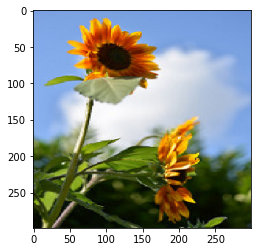

In [151]:
os.chdir('A:\Aniket\AI Projects\Flowers')
path,label = random_image()
img = image.load_img(path,target_size=(299,299))
imshow(img)

x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
y_pred = np.argmax(model.predict(x))
print('\n\nTrue label:{} \nPredicted label:{}'.format(labels[label],labels[y_pred]))

## 7.Evaluating our model  

In [54]:
predictions = model.predict(test_generator)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[38  0  0  0  0]
 [ 2 45  0  0  2]
 [ 1  1 32  2  3]
 [ 1  5  0 30  0]
 [ 0  0  2  0 47]]


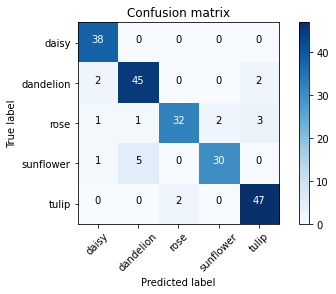

In [55]:
plot_confusion_matrix(confusion_matrix(y_true=test_generator.classes, y_pred = np.argmax(predictions,axis=1)), labels)

In [56]:
print(classification_report(y_true=test_generator.classes, y_pred = np.argmax(predictions,axis=1)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        38
           1       0.88      0.92      0.90        49
           2       0.94      0.82      0.88        39
           3       0.94      0.83      0.88        36
           4       0.90      0.96      0.93        49

    accuracy                           0.91       211
   macro avg       0.91      0.91      0.91       211
weighted avg       0.91      0.91      0.91       211



### As we can see, the model is making predictions with 88% Accuracy